In [ ]:
# TODO
# clear up and comment introductory cell on the general outline delineation procedure

In [1]:
# Code to delineate subglacial lakes using variable outlines based on 
# ice surface height deformation, visualize and quantify lake average
# dh/dt and dv/dt. 
#
# Written 2022-06-06 by W. Sauthoff (sauthoff@mines.edu)

# import packages
import rioxarray as rx
import matplotlib.pyplot as plt
import cmocean
from shapely.geometry import box
from skimage import measure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import matplotlib.dates as mdates

In [2]:
# define data and script directory (replace with your data directory file path) and file path
data_dir = '/Volumes/Extreme SSD/data'
script_dir = '/Users/Wilson/Documents/0-code/scripts'
# point to ATL15 data granuale
# https://doi.org/10.5067/ATLAS/ATL15.001
file = data_dir + '/altimetry/ICESat-2/ATL15.001-Ant/ATL15_AA_0311_01km_001_01.nc'

In [3]:
# open ATL15 file with rioxarray
ATL15_dh=rx.open_rasterio(file, group='delta_h', masked=True)
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4521, x: 5521, band: 1, time: 12)
Coordinates:
  * y                    (y) float64 2.32e+06 2.319e+06 ... -2.199e+06 -2.2e+06
  * x                    (x) float64 -2.72e+06 -2.719e+06 ... 2.799e+06 2.8e+06
  * band                 (band) int64 1
    Polar_Stereographic  int64 0
  * time                 (time) float64 273.9 365.2 ... 1.187e+03 1.278e+03
Data variables:
    cell_area            (band, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (band, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             70616089.15128851
    time_coverage_end:                  2021-06-23T16:19:43.177120Z
    time_coverage_start:                2019-03-29T08:44:54.025831Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [4]:
# import subglacial lake outlines 
outlines = open(script_dir + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(script_dir + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

# drop outlines from SiegfiedFricker2018_outlines that are duplicative of Smith2009_outlines
SiegfriedFricker2018_outlines.drop(SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['cite'].str.contains('Smith and others, 2009')].index, inplace=True)

In [ ]:
# introduction to delineation method
# def IS2_var_outline_plot(lakename, thres): 
'''
Create dh/dt plots around of on-lake and off-lake heights using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018.
Create time-variable outlines using skimage contour, then clip data to variable outline and plot. 
'''
lakename = 'Slessor_23' # HARD CODED TO DEBUG FUNC
thres = 0.5 # HARD CODED TO DEBUG FUNC
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# find appropriate color map scale
height_anom_pos = []
height_anom_neg = []
for cyc in range(len(ATL15_dh_sub.time)-1):
    pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    height_anom_pos += [pos]
    height_anom_neg += [neg]
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
v = np.round(max(max_height_anom_pos,abs(max_height_anom_neg)))
# for discrete colorbar using levels kwarg
# n=int(2*v) # double for pos/neg
# levels = np.linspace(-v, v, n+1) # add 1 to n to account for 0
# for idx in range(len(ATL15_dh_sub.delta_h)): 
idx = 3 # hard coded to debug
# plot figure
fig, ax = plt.subplots(figsize=(8,8))
dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
    origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
# create contours of ice surface elevation height changes to delineate lake outlines
contours = []
contour = measure.find_contours(dhdt.values, thres)
if len(contour) > 0: 
    contours += [contour]
contour = measure.find_contours(dhdt.values, -thres)
if len(contour) > 0: 
    contours += [contour]
# create mapping conversion factor to map array location to polar stereographic x,y
x_conv = (x_max-x_min)/dhdt.shape[1]
y_conv = (y_max-y_min)/dhdt.shape[0]
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        ax.plot(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv, linewidth=2)
# make polygons from contours
polys = []
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        poly = Polygon(list(zip(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv))) 
        polys += [poly]
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.set_xlabel('polar stereographic x [m]', size=15)
ax.set_ylabel('polar stereographic y [m]', size=15)
ax.ticklabel_format(axis='both',scilimits=(0,0))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('Height (h) change from previous cycle [m]', size=15)
plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-var-outline-dhdt-plots/IS2-dvdt-{}-{}.png'.format(lakename,XX), dpi=300, bbox_inches = "tight")
plt.close()

# CODE TO VERIFY WORKING PROPERLY
# # clip ATL15 data to just show (first set crs)
# dhdt.rio.write_crs(3031, inplace=True)
# dhdt_mod = dhdt.rio.clip(polys, drop=False, invert=False)
# # calculate lake avg. dh/dt
# avg_lk_dhdt = np.nanmean(dhdt_mod)

# fig, ax = plt.subplots(figsize=(8,8))
# img = ax.imshow(dhdt_mod, extent=[x_min, x_max, y_min, y_max], 
#     origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
# for i in range(len(contours)): 
#     for j in range(len(contours[0])):
#         ax.plot(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv, linewidth=2)
# SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
# ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
# ax.ticklabel_format(axis='both',scilimits=(0,0))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# fig.colorbar(img, cax=cax).set_label('Height change from previous cycle [m]', size=15)

NameError: name 'XX' is not defined

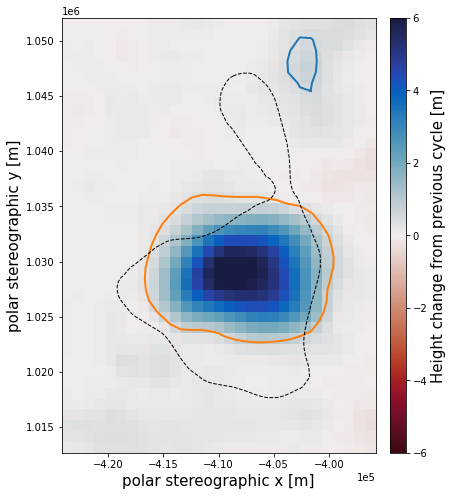

In [144]:
# def IS2_var_outline_plot(lakename, thres): 
'''
Create dh/dt plots around of on-lake and off-lake heights using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018.
Create time-variable outlines using skimage contour, then clip data to variable outline and plot. 
'''
lakename = 'Slessor_23' # HARD CODED TO DEBUG FUNC
thres = 0.5 # HARD CODED TO DEBUG FUNC
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# find appropriate color map scale
height_anom_pos = []
height_anom_neg = []
for cyc in range(len(ATL15_dh_sub.time)-1):
    pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
    height_anom_pos += [pos]
    height_anom_neg += [neg]
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
v = np.round(max(max_height_anom_pos,abs(max_height_anom_neg)))
# for discrete colorbar using levels kwarg
# n=int(2*v) # double for pos/neg
# levels = np.linspace(-v, v, n+1) # add 1 to n to account for 0
# for idx in range(len(ATL15_dh_sub.delta_h)): 
idx = 3 # hard coded to debug
# plot figure
fig, ax = plt.subplots(figsize=(8,8))
dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
    origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
# create contours of ice surface elevation height changes to delineate lake outlines
contours = []
contour = measure.find_contours(dhdt.values, thres)
if len(contour) > 0: 
    contours += [contour]
contour = measure.find_contours(dhdt.values, -thres)
if len(contour) > 0: 
    contours += [contour]
# create mapping conversion factor to map array location to polar stereographic x,y
x_conv = (x_max-x_min)/dhdt.shape[1]
y_conv = (y_max-y_min)/dhdt.shape[0]
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        ax.plot(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv, linewidth=2)
# make polygons from contours
polys = []
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        poly = Polygon(list(zip(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv))) 
        polys += [poly]
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.set_xlabel('polar stereographic x [m]', size=15)
ax.set_ylabel('polar stereographic y [m]', size=15)
ax.ticklabel_format(axis='both',scilimits=(0,0))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('Height (h) change from previous cycle [m]', size=15)
plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-var-outline-dhdt-plots/IS2-dvdt-{}-{}.png'.format(lakename,XX), dpi=300, bbox_inches = "tight")
plt.close()

# plot clipped data that will be used for on-lake averages of dh/dt and dv/dt
# clip ATL15 data to just show (first set crs)
dhdt.rio.write_crs(3031, inplace=True)
dhdt_mod = dhdt.rio.clip(polys, drop=False, invert=False)
# calculate lake avg. dh/dt
avg_lk_dhdt = np.nanmean(dhdt_mod)

fig, ax = plt.subplots(figsize=(8,8))
img = ax.imshow(dhdt_mod, extent=[x_min, x_max, y_min, y_max], 
    origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        ax.plot(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv, linewidth=2)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.ticklabel_format(axis='both',scilimits=(0,0))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('Height change from previous cycle [m]', size=15)

# calculate on-lake averages of dh/dt and dv/dt

In [ ]:
for idx in range(len(SiegfriedFricker2018_outlines)):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    ATL15_dhdvdt_time_series(lakename)

146992193.36731166
146992193.36731166
3.2802024
[3.2802024]
482164143.8130314
[482164143.8130314]


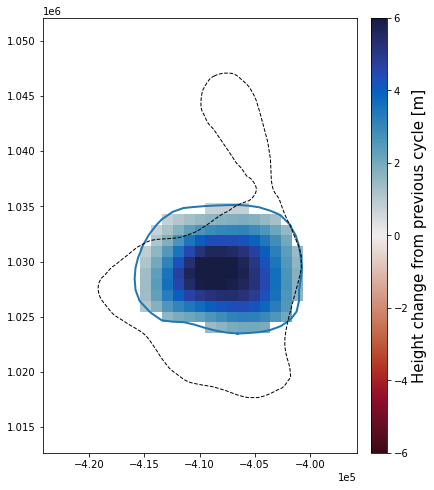

In [122]:
# def ATL15_var_outline_dhdvdt(lakename,thres): 
'''
Function to calculate the lake avg. dh/dt and dv/dt using time-variable outlines.
'''
lakename = 'Slessor_23' # hardcoding until func debugged
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# creat empty lists to fill with data
contours = []
IS2_dates = []
IS2_lkavgdhdt = []
IS2_vols = []
thres = 1 # HARD CODED TO DEBUG
# for idx in range(len(ATL15_dh.delta_h)-1): # DEBUGGING
idx=3 # HARD CODED TO DEBUG
dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
cntrs_fill = measure.find_contours(dhdt.values, thres)
contours += [cntrs_fill]
# cntrs_drain = measure.find_contours(dhdt.values, -thres) # DEBUGGING
# contours += [cntrs_drain] # DEBUGGING
# create mapping conversion factor to map array location to polar stereographic x,y
x_conv = (x_max-x_min)/dhdt.shape[1]
y_conv = (y_max-y_min)/dhdt.shape[0]
# create polygon from created contours converting from ndarray coords to polar stereographic x,y
# if len(contours[0]) == 0 & len(contours[1]) == 0: 
if len(contours[0]) == 0: 
    variable_area = 0
    # create dhdt ndarray filled with 0's
    # dhdt_mod = 0/ATL15_dh_sub.delta_h[idx,:,:] #SIMPLIFYING CODE
    dhdt_mod = 0/dhdt
else:
    for contour in contours:
        p = Polygon(list(zip(contour[0][:, 1]*x_conv+x_min, y_max-contour[0][:, 0]*y_conv)))
        # MUST ADD IF ELSE CLAUSES TO PICK FILLING OR DRAINING CONTOUR TO INDEX WITH [0] OR [1] perhaps cycle through all contours with for loop
    variable_area = p.area
    # clip ATL15 data to polygon outline (first set crs)
    dhdt.rio.write_crs(3031, inplace=True)
    dhdt_mod = dhdt.rio.clip([p], drop=False, invert=False)
# calculate mid-cycle dates for plotting
date_time_str = ATL15_dh_sub.attrs['rangeBeginningDateTime'][2:10]
date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
midcycdays = newdate1 - newdate
midcycdate = newdate + midcycdays
IS2_dates += [midcycdate]
# calculate lake avg. dh/dt
avg_lk_dhdt = np.nanmean(dhdt_mod.values)
# avg_lk_dhdt = np.ma.average(np.ma.MaskedArray(dhdt_mod, mask=np.isnan(dhdt_mod)))
IS2_lkavgdhdt += [avg_lk_dhdt]
# calculate dv/dt
vol = avg_lk_dhdt*variable_area
IS2_vols += [vol]
print(variable_area)
print(p.area)
print(avg_lk_dhdt)
print(IS2_lkavgdhdt)
print(vol)
print(IS2_vols)

fig, ax = plt.subplots(figsize=(8,8))
img = ax.imshow(dhdt_mod, extent=[x_min, x_max, y_min, y_max], 
    origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
for i in range(len(contours)): 
    for j in range(len(contours[0])):
        ax.plot(contours[i][j][:, 1]*x_conv+x_min, y_max-contours[i][j][:, 0]*y_conv, linewidth=2)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.ticklabel_format(axis='both',scilimits=(0,0))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('Height change from previous cycle [m]', size=15)

/Users/Wilson/opt/anaconda3/envs/lakeshores/lib/python3.10/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


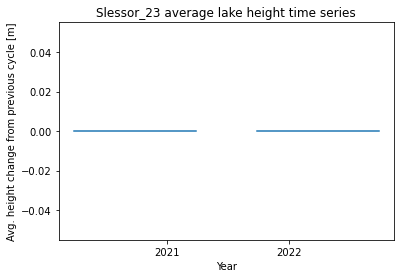

/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_980/3831398559.py:74: UserWarning: Warning: converting a masked element to nan.
  ax.plot(IS2_dates, np.divide(IS2_vols, 1e+9))


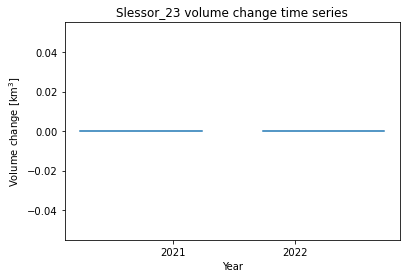

In [14]:
# def ATL15_var_outline_dhdvdt(lakename,thres): 
'''
Function to calculate the lake avg. dh/dt and dv/dt using time-variable outlines.
'''
lakename = 'Slessor_23' # hardcoding until func debugged
# isolate individual lake using gpd buffer
#lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename]
lake_buffer = lake_gpd.buffer(5000)
# define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
# subset ATL15 data set to region of interest
mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
# creat empty lists to fill with data
contours = []
IS2_dates = []
IS2_lkavgdhdt = []
IS2_vols = []
thres = 1 # hard coding to debug func
for idx in range(len(ATL15_dh.delta_h)-1):
    dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
    cntrs_fill = measure.find_contours(dhdt.values, thres)
    contours += [cntrs_fill]
    cntrs_drain = measure.find_contours(dhdt.values, -thres)
    contours += [cntrs_drain]
    # create mapping conversion factor to map array location to polar stereographic x,y
    x_conv = (x_max-x_min)/ATL15_dh_sub.delta_h.shape[1]
    y_conv = (y_max-y_min)/ATL15_dh_sub.delta_h.shape[0]
    # create polygon from created contours converting from ndarray coords to polar stereographic x,y
    if ((len(contours[0]) == 0) and (len(contours[1]) == 0)):
        variable_area = 0
        # create dhdt ndarray filled with 0's
        dhdt_mod = 0/ATL15_dh_sub.delta_h[idx,:,:]  
    else:
        for contour in contours:
            p = Polygon(list(zip(contour[:, 1]*x_conv+x_min, y_max-contour[:, 0]*y_conv)))
        variable_area = p.area
        # clip ATL15 data to polygon outline (first set crs)
        dhdt.rio.write_crs(3031, inplace=True)
        ATL15_dh_sub_clipped = dhdt.rio.clip([p], drop=False, invert=False) # drop=False, FIGURE OUT WHAT THIS KWARG DOES
        dhdt_mod = ATL15_dh_sub_clipped
    # calculate lake avg. dh/dt
    avg_lk_dhdt = np.ma.average(np.ma.MaskedArray(dhdt_mod, mask=np.isnan(dhdt_mod)))
    IS2_lkavgdhdt += [avg_lk_dhdt]
    # calculate dv/dt
    vol = avg_lk_dhdt*variable_area
    IS2_vols += [vol]
    # calculate mid-cycle dates for plotting
    date_time_str = ATL15_dh_sub.attrs['rangeBeginningDateTime'][2:10]
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
    newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays
    IS2_dates += [midcycdate]
# plot average lake height time series
fig, ax = plt.subplots()
ax.plot(IS2_dates, IS2_lkavgdhdt)
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('{} average lake height time series'.format(lakename))
ax.set_xlabel('Year')
ax.set_ylabel('Avg. height change from previous cycle [m]')
# plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-avglkdhdt-lineplots-varoutlines/IS2-avglkdhdt-{}.png'.format(lakename), dpi=300, bbox_inches = "tight")
# plt.close()
# plot volume change time series
plt.show()
fig, ax = plt.subplots()
ax.plot(IS2_dates, np.divide(IS2_vols, 1e+9))
locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_title('{} volume change time series'.format(lakename))
ax.set_xlabel('Year')
ax.set_ylabel('Volume change [km$^3$]')
# plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-dvdt-lineplots-varoutlines/IS2-dvdt-{}.png'.format(lakename), dpi=300, bbox_inches = "tight")
# plt.close()
plt.show()